In [1]:
# trace_plotting.py
# Avery Krieger 11/2022, adapted components from Tim Currier and Max Turner

# argumenmts: [1] date (yyyy-mm-dd); [2] series_number; [3] roi_set_name
# implementation: save_strfs.py 2022-03-17 1 roi_set_postfrom visanalysis.analysis import imaging_data, shared_analysis

import os
from pathlib import Path

import matplotlib.patches as mpatches  # for the legend patches
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from scipy import interpolate
from two_photon_analysis import medulla_analysis as ma
from visanalysis.analysis import imaging_data, shared_analysis
from matplotlib.ticker import FixedLocator, FixedFormatter


def plotEachROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name, 
                                   series_number, roi_set_name):

    time_vector, epoch_response = ma.getAltEpochResponseMatrix(ID, np.vstack(roi_data['roi_response']), alt_pre_time=alt_pre_time, dff=dff, df=df)
    roi_number = len(roi_data['roi_response'])

    roi_number = roi_data["epoch_response"].shape[0]
    # copy from plotConditionedROIResponses
    fh, ax = plt.subplots(roi_number, 1, figsize=(25, 25*roi_number))
    color = plt.cm.tab20(np.linspace(0, 1, roi_number))
    end_time = np.ceil(roi_data['time_vector'][-1]) + 1
    x_locator = FixedLocator(list(range(-1, 16)))

    #[x.set_ylim([-0.55, +1.6]) for x in ax.ravel()] # list comprehension makes each axis have the same limit for comparisons
    for roi_ind in range(roi_number):
        query = {'opto_stim': False}
        # For no opto condition
        no_opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        noOptoMean = np.mean(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_plus = noOptoMean + sem(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_minus = noOptoMean - sem(no_opto_trials[roi_ind, :, :], axis=0)
        ax[roi_ind].plot(roi_data['time_vector'],
            noOptoMean, color='m', alpha=1.0)
        ax[roi_ind].fill_between(roi_data['time_vector'],
            nopt_sem_plus, nopt_sem_minus, color=color[roi_ind], alpha=0.8)

        query = {'opto_stim': True}
        # For no opto condition
        opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        optoMean = np.mean(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_plus = optoMean + sem(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_minus = optoMean - sem(opto_trials[roi_ind, :, :], axis=0)
        ax[roi_ind].plot(roi_data['time_vector'],
            optoMean, color='k', alpha=0.9)
        ax[roi_ind].fill_between(roi_data['time_vector'],
            opto_sem_plus, opto_sem_minus, color='g', alpha=0.6)
        ax[roi_ind].set_title(f'{experiment_file_name} Series: {series_number} {roi_set_name} | ROI: {roi_ind}', fontsize=20)
        #ax[roi_ind].set_title(f'ROI:{roi_ind}', fontsize=20)

        # axes fuckery
        #ax[roi_ind].xaxis.grid(True)
        ax[roi_ind].grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
        ax[roi_ind].xaxis.set_major_locator(x_locator)
        ax[roi_ind].tick_params(axis="x", direction="in", length=16, width=2, color="turquoise")
        ax[roi_ind].grid(axis="y", color="k", alpha=.5, linewidth=.5)


    if savefig == True:
        fh.savefig(
            save_directory
            + "RawTraces."
            + str(experiment_file_name)
            + ".Series "
            + str(series_number)
            + "."
            + str(roi_set_name)
            + ".pdf",
            dpi=300,
        )
        
def plotAcrossROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name, 
                                   series_number, roi_set_name):

    time_vector, epoch_response = ma.getAltEpochResponseMatrix(ID, np.vstack(roi_data['roi_response']), alt_pre_time=alt_pre_time, dff=dff, df=df)
    roi_number = len(roi_data['roi_response'])

    #initialize:
    len_trial = len(roi_data['time_vector'])
    ROI_no_opto_trials = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_minus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_trials = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_minus = np.empty(shape=[0, len_trial])
    
    #[x.set_ylim([-0.55, +1.6]) for x in ax.ravel()] # list comprehension makes each axis have the same limit for comparisons
    for roi_ind in range(roi_number):
        query = {'opto_stim': False}
        # For no opto condition
        no_opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        noOptoMean = np.mean(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_plus = noOptoMean + sem(no_opto_trials[roi_ind, :, :], axis=0)
        nopt_sem_minus = noOptoMean - sem(no_opto_trials[roi_ind, :, :], axis=0)

        query = {'opto_stim': True}
        # For no opto condition
        opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
        optoMean = np.mean(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_plus = optoMean + sem(opto_trials[roi_ind, :, :], axis=0)
        opto_sem_minus = optoMean - sem(opto_trials[roi_ind, :, :], axis=0)

        ROI_no_opto_trials = np.append(ROI_no_opto_trials, [noOptoMean], axis = 0)  
        ROI_no_opto_sem_plus = np.append(ROI_no_opto_sem_plus, [nopt_sem_plus], axis = 0)
        ROI_no_opto_sem_minus = np.append(ROI_no_opto_sem_minus, [nopt_sem_minus], axis = 0)
        ROI_yes_opto_trials = np.append(ROI_yes_opto_trials, [optoMean], axis = 0)
        ROI_yes_opto_sem_plus = np.append(ROI_yes_opto_sem_plus, [opto_sem_plus], axis = 0)
        ROI_yes_opto_sem_minus = np.append(ROI_yes_opto_sem_minus, [opto_sem_minus], axis = 0)
    
    # Some averaging!
    mean_ROI_no_opto_trials = np.mean(ROI_no_opto_trials, axis = 0)
    mean_ROI_no_opto_sem_plus = np.mean(ROI_no_opto_sem_plus, axis = 0)
    mean_ROI_no_opto_sem_minus = np.mean(ROI_no_opto_sem_minus, axis = 0)
    mean_ROI_yes_opto_trials = np.mean(ROI_yes_opto_trials, axis = 0)
    mean_ROI_yes_opto_sem_plus = np.mean(ROI_yes_opto_sem_plus, axis = 0)
    mean_ROI_yes_opto_sem_minus = np.mean(ROI_yes_opto_sem_minus, axis = 0)
    total_ROI_count = ROI_no_opto_trials.shape[0]
    
    # The actual plotting part
    
    # copy from plotConditionedROIResponses
    fh, ax = plt.subplots(1, 1, figsize=(25, 10))
    end_time = np.ceil(roi_data['time_vector'][-1]) + 1
    x_locator = FixedLocator(list(range(-1, 16)))


    ax.plot(roi_data['time_vector'],
        mean_ROI_no_opto_trials, color='g', alpha=1.0)
    ax.fill_between(roi_data['time_vector'],
        mean_ROI_no_opto_sem_plus, mean_ROI_no_opto_sem_minus, color='g', alpha=0.8)
        
    ax.plot(roi_data['time_vector'],
            mean_ROI_yes_opto_trials, color='r', alpha=0.9)
    ax.fill_between(roi_data['time_vector'],
        mean_ROI_yes_opto_sem_plus, mean_ROI_yes_opto_sem_minus, color='r', alpha=0.6)
    ax.set_title(f'{experiment_file_name} Series: {series_number} {roi_set_name} | ROI Count: {total_ROI_count}', fontsize=20)

    #ax.axhline(y=0, color='k', alpha=0.5)
    ax.axvline(x=2, color='turquoise')

    
    # axes fuckery
    #ax[roi_ind].xaxis.grid(True)
    ax.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    ax.xaxis.set_major_locator(x_locator)
    ax.tick_params(axis="x", direction="in", length=16, width=2, color="turquoise")
    ax.grid(axis="y", color="k", alpha=.5, linewidth=.5)
        
    if savefig == True:
        fh.savefig(
            save_directory
            + "AcrossROIsRawTraces."
            + str(experiment_file_name)
            + ".Series "
            + str(series_number)
            + "."
            + str(roi_set_name)
            + "."
            + "ROI Count = "
            + str(total_ROI_count)
            + ".pdf",
            dpi=300,
        )

def collapseROIsResponsesAcrossExperiments(expts):
    # Going to collect the difference between no opto and opto b/c there isn't a great way to normalize
    # This will let me compare across trials
    
    #initialize:
    # This bit is just to get the len_trial parameter
    file_path = os.path.join(expts[0, 0], expts[0, 1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts[0, 2], quiet=False)
    roi_data = ID.getRoiResponses(expts[0, 3])
    len_trial = len(roi_data['time_vector'])
    
    # This must be initialized to append the np.array
    ROI_no_opto_trials = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_no_opto_sem_minus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_trials = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_plus = np.empty(shape=[0, len_trial])
    ROI_yes_opto_sem_minus = np.empty(shape=[0, len_trial])
    
    # Loop through experiments 
    for exp in range(0, len(expts)):
        print(f'-------Started Experiment {exp+1} of {len(expts)}!-------\n')
        file_path = os.path.join(expts[exp, 0], expts[exp, 1] + ".hdf5")
        ID = imaging_data.ImagingDataObject(file_path, expts[exp, 2], quiet=False)
        roi_data = ID.getRoiResponses(expts[exp, 3])
        
        time_vector, epoch_response = ma.getAltEpochResponseMatrix(ID, np.vstack(roi_data['roi_response']), dff=dff, df=df)
        roi_number = len(roi_data['roi_response'])

        for roi_ind in range(roi_number):
            query = {'opto_stim': False}
            # For no opto condition
            no_opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
            noOptoMean = np.mean(no_opto_trials[roi_ind, :, :], axis=0)
            nopt_sem_plus = noOptoMean + sem(no_opto_trials[roi_ind, :, :], axis=0)
            nopt_sem_minus = noOptoMean - sem(no_opto_trials[roi_ind, :, :], axis=0)

            query = {'opto_stim': True}
            # For no opto condition
            opto_trials = shared_analysis.filterTrials(epoch_response, ID, query=query)
            optoMean = np.mean(opto_trials[roi_ind, :, :], axis=0)
            opto_sem_plus = optoMean + sem(opto_trials[roi_ind, :, :], axis=0)
            opto_sem_minus = optoMean - sem(opto_trials[roi_ind, :, :], axis=0)

            ROI_no_opto_trials = np.append(ROI_no_opto_trials, [noOptoMean], axis = 0)  
            ROI_no_opto_sem_plus = np.append(ROI_no_opto_sem_plus, [nopt_sem_plus], axis = 0)
            ROI_no_opto_sem_minus = np.append(ROI_no_opto_sem_minus, [nopt_sem_minus], axis = 0)
            ROI_yes_opto_trials = np.append(ROI_yes_opto_trials, [optoMean], axis = 0)
            ROI_yes_opto_sem_plus = np.append(ROI_yes_opto_sem_plus, [opto_sem_plus], axis = 0)
            ROI_yes_opto_sem_minus = np.append(ROI_yes_opto_sem_minus, [opto_sem_minus], axis = 0)

#     # Some averaging!
#     mean_ROI_no_opto_trials = np.mean(ROI_no_opto_trials, axis = 0)
#     mean_ROI_no_opto_sem_plus = np.mean(ROI_no_opto_sem_plus, axis = 0)
#     mean_ROI_no_opto_sem_minus = np.mean(ROI_no_opto_sem_minus, axis = 0)
#     mean_ROI_yes_opto_trials = np.mean(ROI_yes_opto_trials, axis = 0)
#     mean_ROI_yes_opto_sem_plus = np.mean(ROI_yes_opto_sem_plus, axis = 0)
#     mean_ROI_yes_opto_sem_minus = np.mean(ROI_yes_opto_sem_minus, axis = 0)
    total_ROI_count = ROI_no_opto_trials.shape[0]
    
    return (ROI_no_opto_trials, ROI_no_opto_sem_plus, ROI_no_opto_sem_minus,
            ROI_yes_opto_trials, ROI_yes_opto_sem_plus, ROI_yes_opto_sem_minus, 
            total_ROI_count

           )

# Genralizable condition function prep

In [ ]:
# Mi1 Experiments 10.25
mi1_exp0 = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_proximal_mixed"]]
mi1_exp1 = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_proximal_big_opto_response"]]
mi1_exp2 = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_proximal_mixed"]]
mi1_exp3 = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_proximal_mixed"]]

expts = np.concatenate(
                       (mi1_exp0, mi1_exp1, mi1_exp2, mi1_exp3), 
                       axis = 0,
                       )

save_directory = "/Volumes/ROG2TBAK/data/bruker/raw_specific_cell_types/" #+ experiment_file_name + "/"
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
alt_pre_time = 1
df = False
dff = False
saveFig = True

a1, b1, c1, a2, b2, c2, d = collapseResponsesAcrossExperiments(expts)

In [ ]:
# Mi1 Experiments - Full-field noise
mi1_exp1_prox = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_proximal"]]
mi1_exp1_medi = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_medial"]]
mi1_exp1_dist = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_distal"]]

mi1_exp2_prox = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_proximal"]]
mi1_exp2_medi = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_medial"]]
mi1_exp2_dist = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_distal"]]

mi1_exp3_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_proximal"]]
mi1_exp3_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_medial"]]
mi1_exp3_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_distal"]]

mi1_exp4_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_proximal"]]
mi1_exp4_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_medial"]]
mi1_exp4_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_distal"]]

mi1_exp5_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_proximal"]]
mi1_exp5_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_medial"]]
mi1_exp5_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_distal"]]

expts_prox = np.concatenate(
                       (#mi1_exp0_prox, 
                        mi1_exp1_prox, mi1_exp2_prox,
                        mi1_exp3_prox, mi1_exp4_prox, mi1_exp5_prox), 
                        axis = 0,
                      )
expts_medi = np.concatenate(
                       (#mi1_exp0_medi, 
                        mi1_exp1_medi, mi1_exp2_medi,
                        mi1_exp3_medi, mi1_exp4_medi, mi1_exp5_medi), 
                        axis = 0,
                      )
expts_dist = np.concatenate(
                       (#mi1_exp0_dist, 
                        mi1_exp1_dist, mi1_exp2_dist,
                        mi1_exp3_dist, mi1_exp4_dist, mi1_exp5_dist), 
                        axis = 0,
                      )
single_roi = True

expts = expts_prox

In [ ]:
# Collapsing and plotting across ROIs for this exp
# Each layer is its own plot

save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/" #+ experiment_file_name + "/"
print(save_directory)
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
df = False
dff = False
savefig = True

# Loop through experiments and plot it
for layer in range(0, len(expts_all_layers)):
    print(f'-------Started Layer {layer+1} of {len(expts_all_layers)}!-------\n')
    file_path = os.path.join(expts_all_layers[layer, 0], expts_all_layers[layer, 1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts_all_layers[layer, 2], quiet=True)
    roi_data = ID.getRoiResponses(expts_all_layers[layer, 3])
    
    plotAcrossROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                     dff, df, experiment_file_name = expts_all_layers[layer,1], 
                                     series_number = expts_all_layers[layer,2], 
                                     roi_set_name = expts_all_layers[layer,3])

/Volumes/ABK2TBData/lab_repo/analysis/outputs/


NameError: name 'expts_all_layers' is not defined

In [22]:
ID.getEpochParameters()[1]

{'angle': 0,
 'color': 0.0,
 'current_intensity': 0.0,
 'epoch_time': '11:55:21.460763',
 'height': 240.0,
 'name': 'MovingPatch',
 'phi': -30.0,
 'sphere_radius': 1,
 'theta': 0.0,
 'width': 240.0}

In [ ]:
# L2 Experiments
l2_exp0 = [["/Volumes/ROG2TBAK/data/bruker/20221101", "2022-11-01", "2", "L2_modulated"]]
l2_exp1 = [["/Volumes/ROG2TBAK/data/bruker/20221101", "2022-11-01", "6", "L2_modulated"]]

expts = np.concatenate(
                       (l2_exp0, l2_exp1), 
                       axis = 0
                      )

In [ ]:
# Mi1 Experiments - Full-field noise
mi1_expts_prox = [["/Volumes/ROG2TBAK/data/bruker/20221129", "2022-11-29", "4", "Mi1_proximal"]]
mi1_expts_medi = [["/Volumes/ROG2TBAK/data/bruker/20221129", "2022-11-29", "4", "Mi1_medial"]]
mi1_expts_dist = [["/Volumes/ROG2TBAK/data/bruker/20221129", "2022-11-29", "4", "Mi1_distal"]]

expts_all_layers = np.concatenate(
                       (mi1_expts_prox, mi1_expts_medi, mi1_expts_dist), 
                        axis = 0,
                      )
alt_pre_time = 2
single_roi = True

condition_name = 'current_led_intensity'

In [ ]:
# Opto intensity sweep w/ flash experiments (non moco)

mi1_expts_prox = [["/Volumes/ROG2TBAK/data/bruker/20221122", "2022-11-22", "3", "Mi1_proximal"]]
mi1_expts_medi = [["/Volumes/ROG2TBAK/data/bruker/20221122", "2022-11-22", "3", "Mi1_medial"]]
mi1_expts_dist = [["/Volumes/ROG2TBAK/data/bruker/20221122", "2022-11-22", "3", "Mi1_distal"]]

expts_all_layers = np.concatenate(
                       (mi1_expts_prox, mi1_expts_medi, mi1_expts_dist), 
                        axis = 0,
                      )
alt_pre_time = 2
single_roi = True

condition_name = 'current_led_intensity'

In [21]:
# Opto intensity sweep w/ flash experiments (with MoCo!) 2/8/22

# Multiple ROIs
# Fly 1
mi1_fly1_prox = [["/Volumes/ABK2TBData/data_repo/bruker/20221122.common_moco", "2022-11-22", "3", "proximal_multiple"]]
mi1_fly1_medi = [["/Volumes/ABK2TBData/data_repo/bruker/20221122.common_moco", "2022-11-22", "3", "medial_multiple"]]
mi1_fly1_dist = [["/Volumes/ABK2TBData/data_repo/bruker/20221122.common_moco", "2022-11-22", "3", "distal_multiple"]]
# Fly 2
mi1_fly2_prox = [["/Volumes/ABK2TBData/data_repo/bruker/20221129.common_moco", "2022-11-29", "4", "proximal_multiple"]]
mi1_fly2_medi = [["/Volumes/ABK2TBData/data_repo/bruker/20221129.common_moco", "2022-11-29", "4", "medial_multiple_all"]] #also 'medial_multiple_sub1", "medial_multiple_sub2"
mi1_fly2_dist = [["/Volumes/ABK2TBData/data_repo/bruker/20221129.common_moco", "2022-11-29", "4", "distal_multiple"]]
mi1_prox_all = np.concatenate(
                       (mi1_fly1_prox, mi1_fly2_prox,), 
                        axis = 0,
                      )
mi1_medi_all = np.concatenate(
                       (mi1_fly1_medi, mi1_fly2_medi,), 
                        axis = 0,
                      )
mi1_dist_all = np.concatenate(
                       (mi1_fly1_dist, mi1_fly2_dist,), 
                        axis = 0,
                      )
mi1_all_multiple = np.concatenate(
                                  (mi1_fly1_prox, mi1_fly2_prox,mi1_fly1_medi, mi1_fly2_medi,mi1_fly1_dist, mi1_fly2_dist,),
                                   axis = 0,
                                 )


# Single ROI
# Fly 1
mi1_fly1_prox_single = [["/Volumes/ABK2TBData/data_repo/bruker/20221122.common_moco", "2022-11-22", "3", "proximal_single"]]
mi1_fly1_medi_single = [["/Volumes/ABK2TBData/data_repo/bruker/20221122.common_moco", "2022-11-22", "3", "medial_single"]]
mi1_fly1_dist_single = [["/Volumes/ABK2TBData/data_repo/bruker/20221122.common_moco", "2022-11-22", "3", "distal_single"]]
# Fly 2
mi1_fly2_prox_single = [["/Volumes/ABK2TBData/data_repo/bruker/20221129.common_moco", "2022-11-29", "4", "proximal_single"]]
mi1_fly2_medi_single = [["/Volumes/ABK2TBData/data_repo/bruker/20221129.common_moco", "2022-11-29", "4", "medial_single"]] 
mi1_fly2_dist_single = [["/Volumes/ABK2TBData/data_repo/bruker/20221129.common_moco", "2022-11-29", "4", "distal_single"]]
mi1_prox_all_single = np.concatenate(
                       (mi1_fly1_prox_single, mi1_fly2_prox_single,), 
                        axis = 0,
                       )

mi1_medi_all_single = np.concatenate(
                       (mi1_fly1_medi_single, mi1_fly2_medi_single,), 
                        axis = 0,
                      )

mi1_dist_all_single = np.concatenate(
                       (mi1_fly1_dist_single, mi1_fly2_dist_single,), 
                        axis = 0,
                      )
mi1_all_single = np.concatenate(
                                (mi1_fly1_prox_single, mi1_fly2_prox_single, mi1_fly1_medi_single, mi1_fly2_medi_single,
                                 mi1_fly1_dist_single, mi1_fly2_dist_single,),
                                 axis = 0,
                               )

alt_pre_time = 2
single_roi = True

condition_name = 'current_led_intensity'

In [19]:
# AstA addition experiments
exp1_prox = [["/Volumes/ABK2TBData/data_repo/bruker/20221206", "2022-12-06", "5", "proximal"]]
exp2_prox = [["/Volumes/ABK2TBData/data_repo/bruker/20221206", "2022-12-06", "6", "proximal"]]
exp3_prox = [["/Volumes/ABK2TBData/data_repo/bruker/20221206", "2022-12-06", "7", "proximal"]]
exp4_prox = [["/Volumes/ABK2TBData/data_repo/bruker/20221206", "2022-12-06", "8", "proximal"]]

expts = np.concatenate(
    (exp1_prox, exp2_prox, exp3_prox, exp4_prox), axis = 0,
)

single_roi = True

save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/" #+ experiment_file_name + "/"
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
df = False
dff = False
saveFig = False

In [26]:
# Opto parameter sweeps (intensity and duration)
exp_prox = np.array([["/Volumes/ABK2TBData/data_repo/bruker/20221129", "2022-11-29", "1", "proximal"]])
exp_medi = np.array([["/Volumes/ABK2TBData/data_repo/bruker/20221129", "2022-11-29", "1", "medial"]])
exp_dist = np.array([["/Volumes/ABK2TBData/data_repo/bruker/20221129", "2022-11-29", "1", "distal"]])

single_roi = True

save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/" #+ experiment_file_name + "/"
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
df = False
dff = False
saveFig = False

In [27]:
# condition finder and quick plotter
file_path = os.path.join(exp_prox[0,0], exp_prox[0,1] + ".hdf5")
ID = imaging_data.ImagingDataObject(file_path, exp_prox[0,2], quiet=True)
roi_data = ID.getRoiResponses(exp_prox[0,3])
roi_number = len(roi_data['roi_response'])

print(f'Epoch Parameters:\n{ID.getEpochParameters()[5]}')
print('\n')
print(f'Run Parameters:\n{ID.getRunParameters()}')
roi_responses = ID.getRoiResponses('proximal')
roi_number = len(roi_responses['roi_response'])
#conditions = np.unique(ID.getEpochParameters(condition_name))
#num_conditions = len(conditions)
time_vector, epoch_response = ma.getAltEpochResponseMatrix(
                                                            ID, np.vstack(roi_data['roi_response']), 
                                                            alt_pre_time=alt_pre_time, dff=dff, df=df,
                                                            )
len_trial = len(roi_data['time_vector'])
print(len_trial)

Epoch Parameters:
{'current_led_duration': 2.0, 'current_led_intensity': 1.0, 'epoch_time': '10:07:24.920377'}


Run Parameters:
{'idle_color': 0.5, 'led_duration': array([0.25, 0.5 , 2.  , 4.  ]), 'led_intensity': array([0.25, 0.5 , 1.  , 2.  , 4.  ]), 'num_epochs': 150.0, 'pre_time': 2.0, 'protocol_ID': 'OptoStepSeries', 'randomize_order': True, 'run_start_time': '10:05:58.60', 'stim_time': 5.0, 'tail_time': 10.0}


NameError: name 'alt_pre_time' is not defined

In [15]:
# Getting it to work for multiple layers!!
#mi1_expts_prox = ["/Volumes/ROG2TBAK/data/bruker/20221122", "2022-11-22", "3", "Mi1_proximal"]

# Get multiple conditions in here

def getROIResponsebyCondition(expts_list, condition_name, alt_pre_time=2):
    file_path = os.path.join(expts_list[0], expts_list[1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts_list[2], quiet=True)
    roi_data = ID.getRoiResponses(expts_list[3])
    roi_number = len(roi_data['roi_response'])
    
    if isinstance(condition_name, str):
        condition_dim = 'single'
    else:
        condition_dim = 'multi'

    if condition_dim == 'single':
        conditions = np.unique(ID.getEpochParameters(condition_name))
        num_conditions = len(conditions)
    elif condition_dim == 'multi' and all(isinstance(i, str) for i in condition_name):
        for j in len(condition_name):
            conditions[j] = np.unique(ID.getEpochParameters(condition_name[j]))
        count = 0
        for element in conditions:
                count += 1
        num_conditions = count
    time_vector, epoch_response = ma.getAltEpochResponseMatrix(
                                                               ID, np.vstack(roi_data['roi_response']), 
                                                               alt_pre_time=alt_pre_time, dff=dff, df=df,
                                                              )
    len_trial = len(roi_data['time_vector'])

    ROI_conditions_sem_plus = np.empty(shape=[num_conditions, len_trial])
    ROI_conditions_sem_minus = np.empty(shape=[num_conditions, len_trial])
    ROI_conditions_mean = np.empty(shape=[num_conditions, len_trial])


    if condition_dim == 'single':
        for con_ind in range(num_conditions):
            query = {condition_name: conditions[con_ind]}
            trials = shared_analysis.filterTrials(epoch_response, ID, query = query)
            ROI_conditions_mean[con_ind] = np.mean(trials, axis=1)
            ROI_conditions_sem_minus[con_ind] = ROI_conditions_mean[con_ind] - sem(trials, axis=1)
            ROI_conditions_sem_plus[con_ind] = ROI_conditions_mean[con_ind] + sem(trials, axis=1)
    # elif condition_dim == 'multi':
    #     for row_ind in conditions:
    #         for con_ind in range(len(conditions[row_ind])):
    #             query = {condition_name[row_ind]: }
    ## this is bad and probably won't work. Sorry me
    
    return ID, ROI_conditions_mean, ROI_conditions_sem_minus, ROI_conditions_sem_plus, conditions, num_conditions, 

def visFlash(ID):
    pre_time = ID.getRunParameters('pre_time')
    flash_times = ID.getRunParameters('flash_times')
    flash_width = ID.getRunParameters('flash_width')
    
    flash_start = flash_times + pre_time
    flash_end = flash_start + flash_width
    
    return flash_start, flash_end

def plotRawROIResponseByCondition(ROI_conditions_mean, ROI_conditions_sem_minus, 
                                  ROI_conditions_sem_plus, conditions, num_conditions,
                                  ID, expts_list, plot_error_bars = False, savefig = False,
                                 ):
    # Colormap setting
    cmap = plt.get_cmap('PRGn') # also 'cool' 'winter' 'PRGn' 'Pastel1' 'YlGnBu' 'twilight'
    colors = [cmap(i) for i in np.linspace(0.1, 1.0, num_conditions)]
    
    # Plotting
    fh, ax = plt.subplots(1, 1, figsize=(25, 10))
    end_time = np.ceil(roi_data['time_vector'][-1]) + 1
    x_locator = FixedLocator(list(range(-1, int(end_time))))

    for con_ind in range(num_conditions):
        ax.plot(roi_data['time_vector'],
                ROI_conditions_mean[con_ind], 
                color=colors[con_ind], alpha=0.9, linewidth=1, 
                label=conditions[con_ind])

        if plot_error_bars:
            ax.fill_between(roi_data['time_vector'],
                            ROI_conditions_sem_plus[con_ind], ROI_conditions_sem_minus[con_ind], 
                            color=colors[con_ind], alpha=0.1)

    if ID.getRunParameters('protocol_ID') == 'FlashSeriesWithOptoStep':
        flash_start, flash_end = visFlash(ID)
        # find max y values:
        min_val = np.min(ROI_conditions_sem_minus)
        max_val = np.max(ROI_conditions_sem_plus)
        y_low = min_val-abs(0.05*min_val)
        y_high = max_val+abs(0.05*max_val)
               
        # opto stim plotting
        led_start_time = ID.getRunParameters('pre_time')+ID.getRunParameters('led_time')
        led_end_time = led_start_time + ID.getRunParameters('led_duration')        
        ax.fill_between([led_start_time, led_end_time], y_low, y_high, 
                        alpha=0.7, edgecolor='r', facecolor='none', linewidth=3, label='Opto')
        # vis stim plotting
        for vis_ind in range(len(flash_start)):
            if vis_ind < 1:
                flash_label = 'Vis'
            else:
                flash_label = None
            ax.fill_between([flash_start[vis_ind], flash_end[vis_ind]], 
                            y_low+abs(0.1*y_low), y_high-abs(0.1*y_low),
                            alpha=0.4, edgecolor='b', facecolor='none', 
                            linewidth=2, label=flash_label)

    # Legend, Grid, Axis
    ax.legend(loc="upper right", fontsize=20)
    ax.grid(axis="x", color="k", alpha=.1, linewidth=1, linestyle=":")
    ax.xaxis.set_major_locator(x_locator)
    ax.tick_params(axis="x", direction="in", length=16, width=2, color="turquoise")
    ax.grid(axis="y", color="k", alpha=.3, linewidth=.5)
    ax.set_title(f'{expts_list[1]} Series: {expts_list[2]} | DFF={str(dff)} | Conditions: {condition_name} | ROI={expts_list[3]}', fontsize=20)

    if savefig == True:
        fh.savefig(
            f'{save_directory}AcrossConditionRawTraces.{expts_list[2]}.Conditions={condition_name}.ROIs={expts_list[3]}.DFF={str(dff)}.Con={conditions}.jpg',
            dpi=300,

        )

# Running the generalized functions

## For plotting all conditions without error bars

In [25]:
dff = True
for layer_ind in range(expts.shape[0]):
    ID, ROI_conditions_mean, ROI_conditions_sem_minus, ROI_conditions_sem_plus, conditions, num_conditions = getROIResponsebyCondition([layer_ind], condition_name, alt_pre_time=2)
    expts
    plotRawROIResponseByCondition(ROI_conditions_mean, ROI_conditions_sem_minus, 
                                  ROI_conditions_sem_plus, conditions, num_conditions, 
                                  ID, expts_list = expts[layer_ind],
                                  plot_error_bars = False, savefig = False,
                                 )    

NameError: name 'condition_name' is not defined

## For 2 conditions, with error bars

In [ ]:
ID.getEpochParameters

ValueError: could not broadcast input array from shape (6,102) into shape (102,)

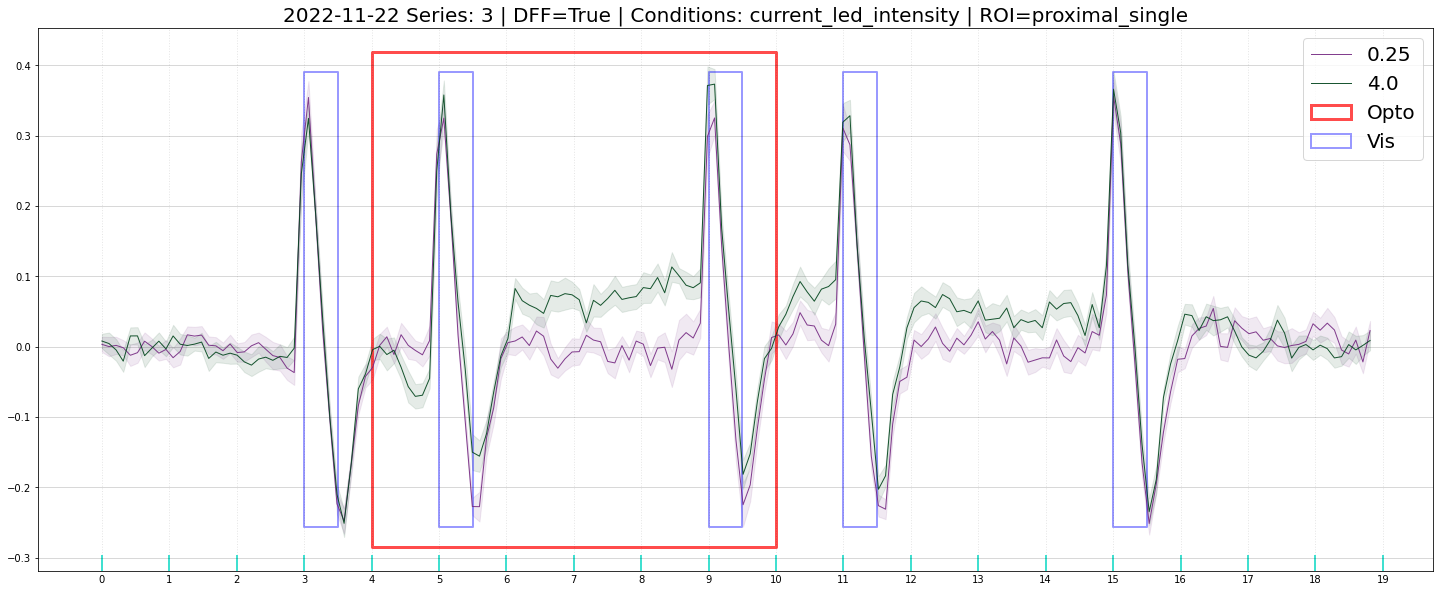

In [25]:
# For motion corrected data:

# B/c plotRawROIResponseByCondition needs it.. fix later
roi_data = ID.getRoiResponses(mi1_all_single[0,3])

dff = True
df = False
for layer_ind in range(mi1_all_single.shape[0]):
    ID, ROI_conditions_mean, ROI_conditions_sem_minus, ROI_conditions_sem_plus, conditions, num_conditions = getROIResponsebyCondition(mi1_all_single[layer_ind], condition_name, alt_pre_time=2)
    
    ROI_conditions_mean = ROI_conditions_mean[(0,4), :]
    ROI_conditions_sem_minus = ROI_conditions_sem_minus[(0,4), :]
    ROI_conditions_sem_plus = ROI_conditions_sem_plus[(0,4), :]
    conditions = np.take(conditions, [0, 4])
    num_conditions = 2
    
    plotRawROIResponseByCondition(ROI_conditions_mean, ROI_conditions_sem_minus, 
                                  ROI_conditions_sem_plus, conditions, num_conditions, 
                                  ID, expts_list = mi1_all_single[layer_ind],
                                  plot_error_bars = True, savefig = False,
                                 )    

In [17]:
dff = True
for layer_ind in range(expts_all_layers.shape[0]):
    ID, ROI_conditions_mean, ROI_conditions_sem_minus, ROI_conditions_sem_plus, conditions, num_conditions = getROIResponsebyCondition(expts_all_layers[layer_ind], condition_name, alt_pre_time=2)
    
    ROI_conditions_mean = ROI_conditions_mean[(0,4), :]
    ROI_conditions_sem_minus = ROI_conditions_sem_minus[(0,4), :]
    ROI_conditions_sem_plus = ROI_conditions_sem_plus[(0,4), :]
    conditions = np.take(conditions, [0, 4])
    num_conditions = 2
    
    plotRawROIResponseByCondition(ROI_conditions_mean, ROI_conditions_sem_minus, 
                                  ROI_conditions_sem_plus, conditions, num_conditions, 
                                  ID, expts_list = expts_all_layers[layer_ind],
                                  plot_error_bars = True, savefig = True,
                                 )    

NameError: name 'expts_all_layers' is not defined

## For Two conditions, not sure what's different

In [26]:
dff = True
for layer_ind in range(expts.shape[0]):
    ID, ROI_conditions_mean, ROI_conditions_sem_minus, ROI_conditions_sem_plus, num_conditions = getROIResponsebyCondition(expts[layer_ind], condition_name, alt_pre_time=2)
    
    ROI_conditions_mean = ROI_conditions_mean[(0,4), :]
    ROI_conditions_sem_minus = ROI_conditions_sem_minus[(0,4), :]
    ROI_conditions_sem_plus = ROI_conditions_sem_plus[(0,4), :]
    num_conditions = 2
    
    plotRawROIResponseByCondition(ROI_conditions_mean, ROI_conditions_sem_minus, 
                                  ROI_conditions_sem_plus, num_conditions, ID,
                                  expts_list = expts_all_layers[layer_ind],
                                  plot_error_bars = True, savefig = False,
                                 )  

NameError: name 'condition_name' is not defined

/Volumes/ABK2TBData/lab_repo/analysis/outputs/
-------Started Experiment 1 of 4!-------

===================TIMING: Channel 0======================
100 Stims presented (of 100 parameterized)
Stim start to start: [min=4.525, median=4.525, max=4.534] / parameterized = 4.500 sec
Stim duration: [min=0.491, median=0.492, max=0.492] / parameterized = 0.500 sec
Dropped 0 / 6000 frames (0.00%)
===================TIMING: Channel 1======================
100 Stims presented (of 100 parameterized)
Stim start to start: [min=4.525, median=4.525, max=4.534] / parameterized = 4.500 sec
Stim duration: [min=0.491, median=0.492, max=0.492] / parameterized = 0.500 sec
Dropped 0 / 6000 frames (0.00%)
===================TIMING: Channel 0======================
100 Stims presented (of 100 parameterized)
Stim start to start: [min=4.525, median=4.525, max=4.534] / parameterized = 4.500 sec
Stim duration: [min=0.491, median=0.492, max=0.492] / parameterized = 0.500 sec
Dropped 0 / 6000 frames (0.00%)
===========

/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


TypeError: 'AxesSubplot' object is not subscriptable

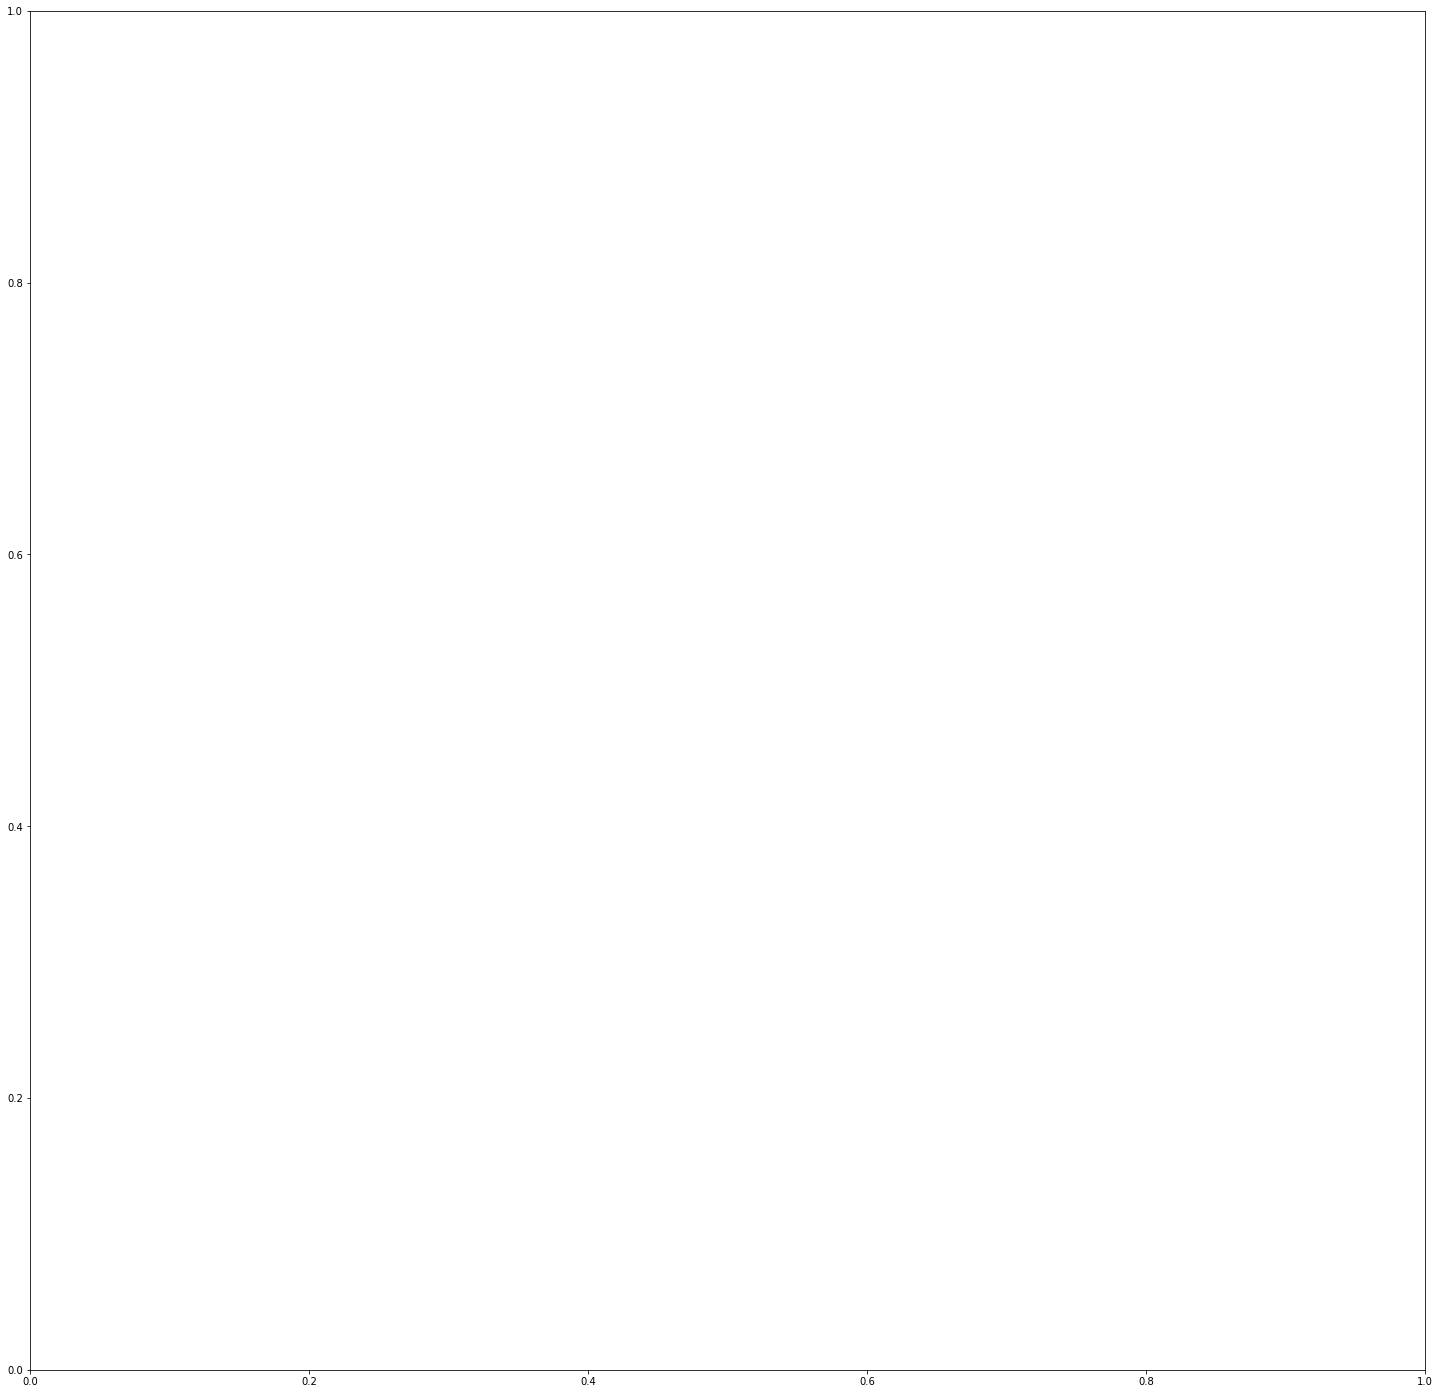

In [16]:
# Plotting each ROI for all expts:

save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/" #+ experiment_file_name + "/"
print(save_directory)
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
alt_pre_time = 1
df = False
dff = False
saveFig = True

# Loop through experiments and plot it
for exp in range(0, len(expts)):
    print(f'-------Started Experiment {exp+1} of {len(expts)}!-------\n')
    file_path = os.path.join(expts[exp, 0], expts[exp, 1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts[exp, 2], quiet=False)
    roi_data = ID.getRoiResponses(expts[exp, 3])
    
    plotEachROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name = expts[exp,1], 
                                   series_number = expts[exp,2], roi_set_name = expts[exp,3])

/Volumes/ABK2TBData/lab_repo/analysis/outputs/
-------Started Experiment 1 of 4!-------



/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------Started Experiment 2 of 4!-------



/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------Started Experiment 3 of 4!-------



/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------Started Experiment 4 of 4!-------



/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


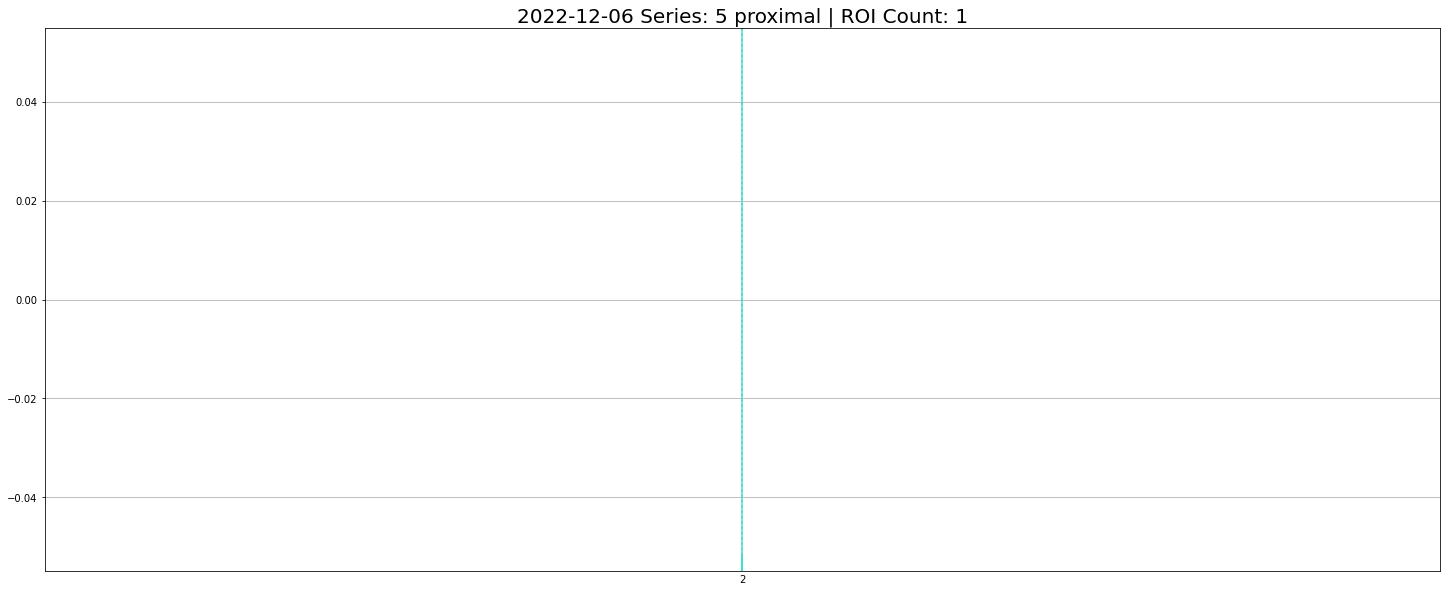

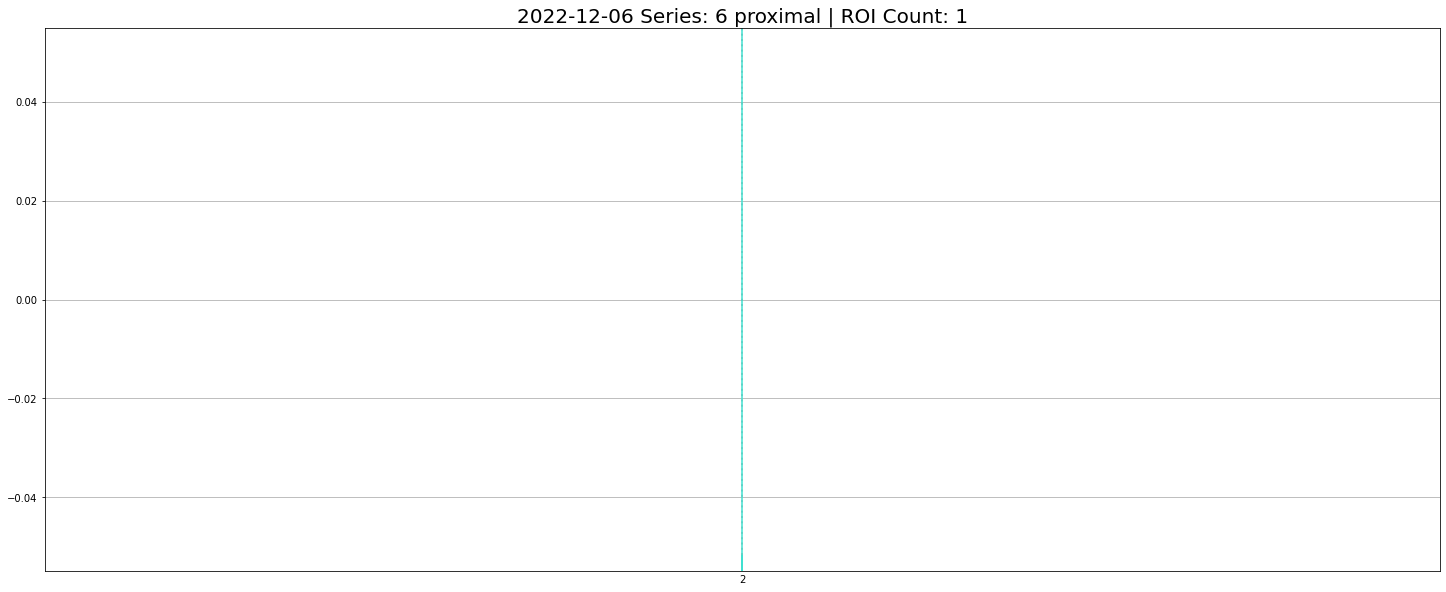

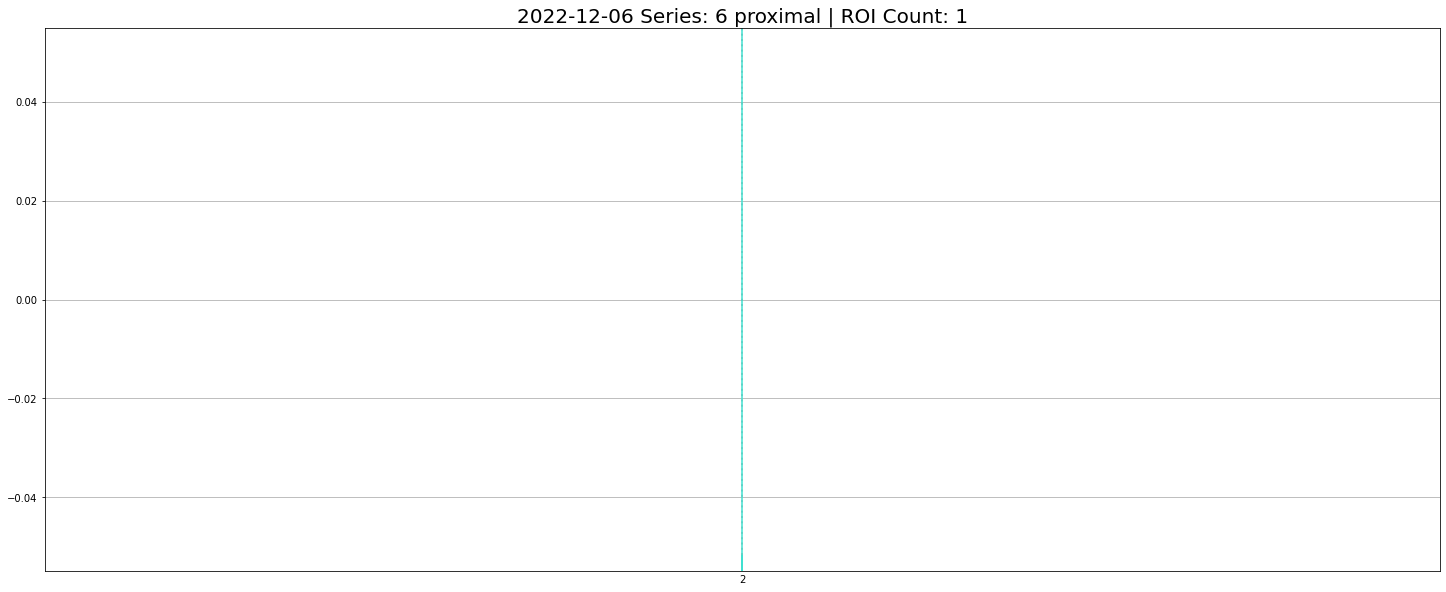

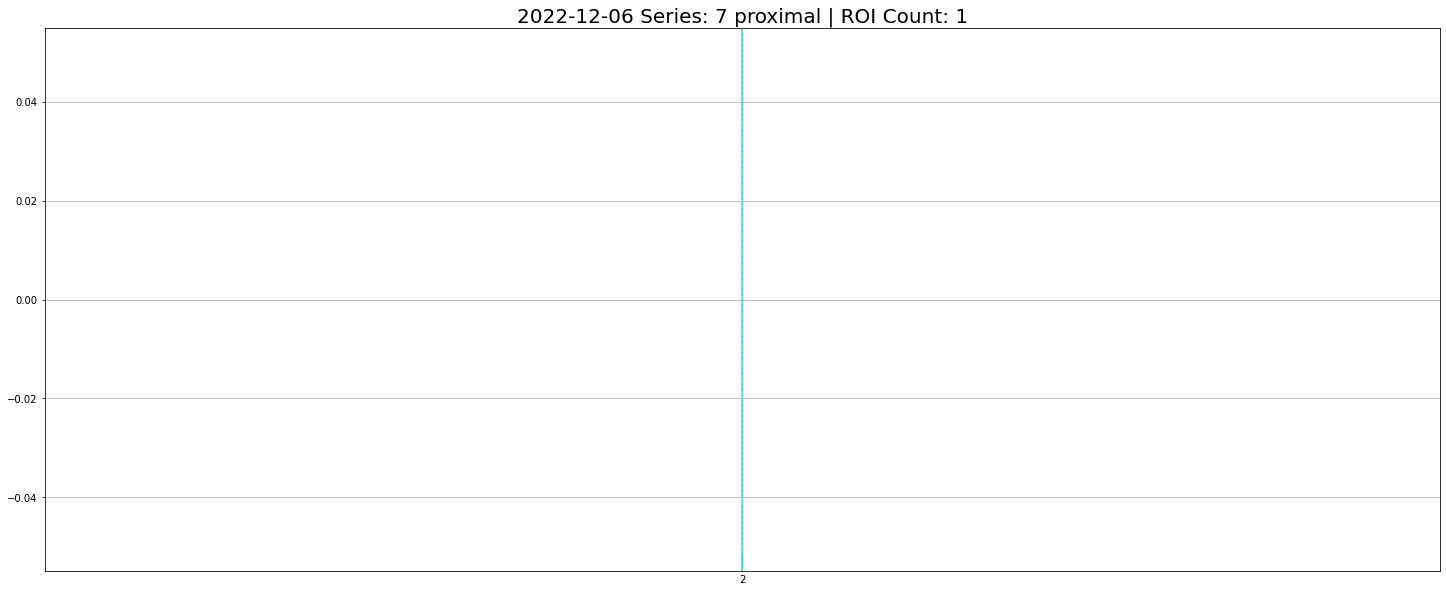

In [20]:
# Collapsing and plotting across ROIs for all expts
# Each experiment is its own plot

save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/" #+ experiment_file_name + "/"
print(save_directory)
Path(save_directory).mkdir(exist_ok=True)
# initialize variables
alt_pre_time = 2
df = False
dff = True
saveFig = False

# Loop through experiments and plot it
for exp in range(0, len(expts)):
    print(f'-------Started Experiment {exp+1} of {len(expts)}!-------\n')
    file_path = os.path.join(expts[exp, 0], expts[exp, 1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, expts[exp, 2], quiet=True)
    roi_data = ID.getRoiResponses(expts[exp, 3])
    
    plotAcrossROIRawSpecificCellType(ID, roi_data, alt_pre_time, 
                                   dff, df, experiment_file_name = expts[exp,1], 
                                   series_number = expts[exp,2], roi_set_name= expts[exp,3])

In [ ]:
def optoSplit(roi_trfs, silent = True):
    # SPLIT into NO Opto and YES Opto trials (alternating)
    no_slice = roi_trfs[:, :, 0::2]  # Every 2 trials, starting at 0
    yes_slice = roi_trfs[:, :, 1::2]  # Every 2 trials, starting at 1

    # compute mean STRF
    # roi_mean_strf = np.mean(roi_strf,3);
    roi_mean_trf = np.mean(roi_trfs, 2)
    nopto_mean_trf = np.mean(no_slice, 2)
    yopto_mean_trf = np.mean(yes_slice, 2)

    # Standard Error of the Mean calculations
    nopto_sem = sem(no_slice, axis=2)  # calculate the no opto sem
    nopto_sem_plus = np.squeeze(nopto_mean_trf + nopto_sem)
    nopto_sem_minus = np.squeeze(nopto_mean_trf - nopto_sem)
    yopto_sem = sem(yes_slice, axis=2)  # calculate the yes opto sem
    yopto_sem_plus = np.squeeze(yopto_mean_trf + yopto_sem)
    yopto_sem_minus = np.squeeze(yopto_mean_trf - yopto_sem)


    if silent == False:
        # Checking ouputs for separating no opto from opto trials
        print("\n----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")
        print("||    Checking the shape of the various trfs to ensure opto/no opto split:!")
        print("||    Shape of roi_trfs is: " + str(roi_trfs.shape))
        print("||    Shape of no_slice is: " + str(no_slice.shape))
        print("||    Shape of yes_slice is: " + str(yes_slice.shape))
        print("||")
        print("||    Shape of roi_mean_trf is: " + str(roi_mean_trf.shape))
        print("||    Shape of nopto_mean_trf is: " + str(nopto_mean_trf.shape))
        print("||    Shape of yopto_mean_trf is: " + str(yopto_mean_trf.shape))
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------\n")

        print(f'shape of std error is {nopto_sem_plus.shape}')
        
    return (roi_mean_trf, nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, 
            yopto_mean_trf, yopto_sem_plus, yopto_sem_minus
           )

# Function for averaging across ROIs

In [ ]:
def avgAcrossROIs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, yopto_mean_trf, yopto_sem_plus, yopto_sem_minus):
    across_roi_nopto_trf = np.mean(nopto_mean_trf, axis = 0)
    across_roi_nopto_sem_plus = np.mean(nopto_sem_plus, axis = 0)
    across_roi_nopto_sem_minus = np.mean(nopto_sem_minus, axis = 0)
    across_roi_yopto_trf = np.mean(yopto_mean_trf, axis = 0)
    across_roi_yopto_sem_plus = np.mean(yopto_sem_plus, axis = 0)
    across_roi_yopto_sem_minus = np.mean(yopto_sem_minus, axis = 0)
    
    return across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus


In [ ]:
# Run function to average across ROIs
across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus = avgAcrossROIs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, yopto_mean_trf, yopto_sem_plus, yopto_sem_minus)

# Filter in Fourier space

In [ ]:
# FFT frequency sample points
def plotFFTFilter(filter_fft, ideal_frame_rate):
    freq = np.fft.fftfreq(n=len(filter_fft), d=1/ideal_frame_rate)

    # Filter power spectrum
    fh, ax = plt.subplots(1, 1, figsize=(6, 3))
    # FFT shift before visualizing
    ax.plot(np.fft.fftshift(freq), np.abs(np.fft.fftshift(filter_fft))**2)
    # ax.plot(np.fft.fftshift(freq), np.fft.fftshift(filter_fft))

    ax.set_xlim([0, 60])
    # ax.set_yscale('log')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power')
    ax.set_title('FFT Filter baby')

    # Conclusion: very little power at high frequencies, no use in doing freq cutoff before ifft

# Everything Below is deprecated!

In [ ]:
print(start_seed)

In [ ]:
# EXPERIMENTAL
# add gray to the pre and post parts of the stimulus 
pre_stim_updates = update_rate*run_parameters["pre_time"]
gray_filler = np.full((int(pre_stim_updates),num_trials), 0.5)

grayed_all_stim = np.concatenate((gray_filler, all_stims, gray_filler), axis=0)